In [2]:
  #import libraries 
    
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
import numpy as np
import datetime as dt
import re  
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [10, 8]

In [3]:
# import datasets to be used

issued=pd.read_csv('Building_Permits_Issued.csv',low_memory=False)

#issued=pd.read_excel('./IssuedBuildingPermits2010toPresent.xlsx')


In [4]:
# import appraised_houses data
SINGLE_FAMILY_2009=pd.read_csv('2009 single family_final_with_sqft.txt')
SINGLE_FAMILY_2013=pd.read_csv('2013 single family_final_with_sqft.txt')
SINGLE_FAMILY_2017=pd.read_csv('2017 single family_final_with_sqft.txt')

In [5]:
# check what the data looks likes

issued.head()

,Permit #,Permit Type Description,Permit Subtype Description,Parcel,Date Entered,Date Issued,Const. Cost,Address,City,State,Zip,Subdivision/Lot,Contact,Permit Type,Permit Subtype,IVR Trk#,Purpose,Council Dist,Census Tract,Mapped Location
0,2018002927,Building Residential - New,Single Family Residence,081160R00100CO,01/18/2018,02/12/2018,206150.0,1017A MONROE ST,NASHVILLE,TN,37208,UNIT A 1017 MONROE,"TRISTAR CONSTRUCTION, INC",CARN,CAA01R301,3439281,to construct 1830SF single family residence wi...,19.0,37019400.0,"1017A MONROE ST\nNASHVILLE, TN 37208\n(36.1740..."
1,201617929,Building Use & Occupancy,"Tents, Stages",09215014800,04/19/2016,04/21/2016,2000.0,2300 WEST END AVE,NASHVILLE,TN,37203,N W CORNER WEST END AVE & 23RD AVE N,Music City Tents & Events Llc,CAUO,CAZ06A001,2116751,PERMIT TO ERECT 1:40X85 TENT. THIS TENT IS BEI...,21.0,37016500.0,"2300 WEST END AVE\nNASHVILLE, TN 37203\n(36.14..."
2,2016049270,Building Sign Permit,Sign - Ground / Wall Signs,11909014000,09/14/2016,09/14/2016,15000.0,2802 NOLENSVILLE PIKE,NASHVILLE,TN,37211,PT LOT 2 PATTERSON SUB,BOZMAN SIGN CO INC,CASN,CAZ02A001,3277064,to install replacement signage for existing fr...,16.0,37017300.0,"2802 NOLENSVILLE PIKE\nNASHVILLE, TN 37211\n(3..."
3,2016029907,Building Residential - Roofing / Siding,Duplex,075150A13900CO,06/20/2016,06/20/2016,17648.0,139 STONERS GLEN DR,HERMITAGE,TN,37076,UNIT 139 STONERS GLEN PHASE 1,"MR ROOF NASHVILLE, LLC",CARK,CAA02R302,3251947,Remove existing shingles and replace with new ...,12.0,37015623.0,"139 STONERS GLEN DR\nHERMITAGE, TN 37076\n(36...."
4,201533533,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",10404024100,08/07/2015,11/17/2015,542696.0,70 MUSIC SQ W,NASHVILLE,TN,37203,LOT 1 O.B. HAYES FIRST PLAN CONSOLIDATION OF L...,Construction Enterprises Inc,CART,CAA03R398,2061885,SEE MASTER PERMIT T2015-26520...T.....GRAND AV...,19.0,37016400.0,"70 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.147074..."


issued.rename(columns={'Permit #': 'PermitNo', 'Permit Type Description':'PermTypeDesc', 'Permit Subtype Description': 'PermSubDesc', 'Parcel':'Parcel', 'Date Entered':'EnteredDt', 'Date Issued': 'IssuedDt', 'Const.Cost': 'ConstCost', 'Address':'Address', 'City':'City', 'State':'State', 'Zip':'Zip', 'Subdivision/Lot': 'Subdiv_Lot', 'Contact':'Contact', 'Per Ty': 'PermType', 'Per SubType': 'PermSubtype', 'IVR Trk#': 'IVRTrk#', 'Purpose':'Purpose', 'Council Dist':'CouncilDist', 'Census Tract':'CensusTract', 'Mapped Location':'MappedLoc'}, inplace=True)

In [6]:
issued=issued.rename(columns={'Permit #': 'PermitNo', 'Permit Type Description':'PermTypeDesc', 'Permit Subtype Description': 'PermSubtypeDesc', 'Parcel':'Parcel', 'Date Entered':'Entered', 'Date Issued': 'Issued', 'Const. Cost': 'ConstCost', 'Address':'Address', 'City':'City', 'State':'State', 'Zip':'Zip', 'Subdivision/Lot': 'SubdLot', 'Contact':'Contact', 'Permit Type': 'PermType', 'Permit Subtype': 'PermSubtype', 'IVR Trk#': 'IVRTrk#', 'Purpose':'Purpose', 'Council Dist':'CouncilDist', 'Census Tract':'CensusTract', 'Mapped Location':'MappedLoc'})

In [7]:
issued.MappedLoc.head()

0    1017A MONROE ST\nNASHVILLE, TN 37208\n(36.1740...
1    2300 WEST END AVE\nNASHVILLE, TN 37203\n(36.14...
2    2802 NOLENSVILLE PIKE\nNASHVILLE, TN 37211\n(3...
3    139 STONERS GLEN DR\nHERMITAGE, TN 37076\n(36....
4    70 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.147074...
Name: MappedLoc, dtype: object

In [8]:
#BuildingPermit['long_lat']=
# BuildingPermit['Mapped Location'].replace('\(.*?\)','',regex=True)


coords=re.compile(r'\(.*?\)')
matches = []
for string in issued.MappedLoc:
   match=re.findall(coords,string)
   matches.append(match)


In [9]:
# matches

In [10]:
matches=pd.DataFrame(matches)


In [11]:
matches.head()

,0,1
0,"(36.174077, -86.797183)",None
1,"(36.148736, -86.804731)",None
2,"(36.112749, -86.746151)",None
3,"(36.196166, -86.60253)",None
4,"(36.147074, -86.793734)",None


In [12]:
# keep only first column
matches=matches.iloc[:,0]



In [13]:
issued=issued.join(matches)

In [14]:
# rename column '0' as 'location'
issued.rename(columns={0:'location'},inplace =True)
issued.head()

,PermitNo,PermTypeDesc,PermSubtypeDesc,Parcel,Entered,Issued,ConstCost,Address,City,State,...,SubdLot,Contact,PermType,PermSubtype,IVRTrk#,Purpose,CouncilDist,CensusTract,MappedLoc,location
0,2018002927,Building Residential - New,Single Family Residence,081160R00100CO,01/18/2018,02/12/2018,206150.0,1017A MONROE ST,NASHVILLE,TN,...,UNIT A 1017 MONROE,"TRISTAR CONSTRUCTION, INC",CARN,CAA01R301,3439281,to construct 1830SF single family residence wi...,19.0,37019400.0,"1017A MONROE ST\nNASHVILLE, TN 37208\n(36.1740...","(36.174077, -86.797183)"
1,201617929,Building Use & Occupancy,"Tents, Stages",09215014800,04/19/2016,04/21/2016,2000.0,2300 WEST END AVE,NASHVILLE,TN,...,N W CORNER WEST END AVE & 23RD AVE N,Music City Tents & Events Llc,CAUO,CAZ06A001,2116751,PERMIT TO ERECT 1:40X85 TENT. THIS TENT IS BEI...,21.0,37016500.0,"2300 WEST END AVE\nNASHVILLE, TN 37203\n(36.14...","(36.148736, -86.804731)"
2,2016049270,Building Sign Permit,Sign - Ground / Wall Signs,11909014000,09/14/2016,09/14/2016,15000.0,2802 NOLENSVILLE PIKE,NASHVILLE,TN,...,PT LOT 2 PATTERSON SUB,BOZMAN SIGN CO INC,CASN,CAZ02A001,3277064,to install replacement signage for existing fr...,16.0,37017300.0,"2802 NOLENSVILLE PIKE\nNASHVILLE, TN 37211\n(3...","(36.112749, -86.746151)"
3,2016029907,Building Residential - Roofing / Siding,Duplex,075150A13900CO,06/20/2016,06/20/2016,17648.0,139 STONERS GLEN DR,HERMITAGE,TN,...,UNIT 139 STONERS GLEN PHASE 1,"MR ROOF NASHVILLE, LLC",CARK,CAA02R302,3251947,Remove existing shingles and replace with new ...,12.0,37015623.0,"139 STONERS GLEN DR\nHERMITAGE, TN 37076\n(36....","(36.196166, -86.60253)"
4,201533533,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",10404024100,08/07/2015,11/17/2015,542696.0,70 MUSIC SQ W,NASHVILLE,TN,...,LOT 1 O.B. HAYES FIRST PLAN CONSOLIDATION OF L...,Construction Enterprises Inc,CART,CAA03R398,2061885,SEE MASTER PERMIT T2015-26520...T.....GRAND AV...,19.0,37016400.0,"70 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.147074...","(36.147074, -86.793734)"


In [15]:
# remove the parenthesis
issued['location']=issued.location.str.replace('(','')

In [16]:
issued['location']=issued.location.str.replace(')','')


In [17]:
# split by strings by comma and assign them to latitude and longitude
location=issued.location.str.split(', ', expand=True)

In [18]:
location.rename(columns={0:'Lat',1:'Long'},inplace=True)


In [19]:
issued_df=issued.join(location)

In [20]:
issued_df.head()

,PermitNo,PermTypeDesc,PermSubtypeDesc,Parcel,Entered,Issued,ConstCost,Address,City,State,...,PermType,PermSubtype,IVRTrk#,Purpose,CouncilDist,CensusTract,MappedLoc,location,Lat,Long
0,2018002927,Building Residential - New,Single Family Residence,081160R00100CO,01/18/2018,02/12/2018,206150.0,1017A MONROE ST,NASHVILLE,TN,...,CARN,CAA01R301,3439281,to construct 1830SF single family residence wi...,19.0,37019400.0,"1017A MONROE ST\nNASHVILLE, TN 37208\n(36.1740...","36.174077, -86.797183",36.174077,-86.797183
1,201617929,Building Use & Occupancy,"Tents, Stages",09215014800,04/19/2016,04/21/2016,2000.0,2300 WEST END AVE,NASHVILLE,TN,...,CAUO,CAZ06A001,2116751,PERMIT TO ERECT 1:40X85 TENT. THIS TENT IS BEI...,21.0,37016500.0,"2300 WEST END AVE\nNASHVILLE, TN 37203\n(36.14...","36.148736, -86.804731",36.148736,-86.804731
2,2016049270,Building Sign Permit,Sign - Ground / Wall Signs,11909014000,09/14/2016,09/14/2016,15000.0,2802 NOLENSVILLE PIKE,NASHVILLE,TN,...,CASN,CAZ02A001,3277064,to install replacement signage for existing fr...,16.0,37017300.0,"2802 NOLENSVILLE PIKE\nNASHVILLE, TN 37211\n(3...","36.112749, -86.746151",36.112749,-86.746151
3,2016029907,Building Residential - Roofing / Siding,Duplex,075150A13900CO,06/20/2016,06/20/2016,17648.0,139 STONERS GLEN DR,HERMITAGE,TN,...,CARK,CAA02R302,3251947,Remove existing shingles and replace with new ...,12.0,37015623.0,"139 STONERS GLEN DR\nHERMITAGE, TN 37076\n(36....","36.196166, -86.60253",36.196166,-86.60253
4,201533533,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",10404024100,08/07/2015,11/17/2015,542696.0,70 MUSIC SQ W,NASHVILLE,TN,...,CART,CAA03R398,2061885,SEE MASTER PERMIT T2015-26520...T.....GRAND AV...,19.0,37016400.0,"70 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.147074...","36.147074, -86.793734",36.147074,-86.793734


In [21]:
# covert Issued date column to datetime format and create a year column from the Issued date
issued['Issued']=pd.to_datetime(issued.Issued)

# create Year column
issued['Year']=issued['Issued'].dt.year

In [22]:
# check data type of location column
issued.location.dtype

dtype('O')

In [23]:
# look what the data looks like
# Land: Land value
# IMPR: Improvement Values
# Total APPR: Total Appraised value 

SINGLE_FAMILY_2009.head()

sf2009=SINGLE_FAMILY_2009.rename(columns={'APN':'APN', 'DistrictCode':'DistrictCode', 'Council District':'DistrictNo', 'AddressFullAddress': 'Address', 'AddressCity':'City', 'AddressPostalCode':'Zip', '2009 LAND':'LandValue', '2009 IMPR':'ImprovementValue', '2009 TOTAL APPR':'AppraisedValue', '2009 TOTAL ASSD':'2009 TOTAL ASSD'})

In [24]:
# to check if there are zero values
sf2009.LandValue.min()

0.0

In [25]:
# rename column names
sf2013=SINGLE_FAMILY_2013.rename(columns={'APN':'APN', 'DistrictCode':'DistrictCode', 'Council District':'DistrictNo', 'AddressFullAddress': 'Address', 'AddressCity':'City', 'AddressPostalCode':'Zip', '2013 LAND':'LandValue', '2013 IMPR':'ImprovementValue', '2013 TOTAL APPR':'AppraisedValue', '2013 TOTAL ASSD':'2013 TOTAL ASSD'})

sf2017=SINGLE_FAMILY_2017.rename(columns={'APN':'APN', 'DistrictCode':'DistrictCode', 'Council District':'DistrictNo', 'AddressFullAddress': 'Address', 'AddressCity':'City', 'AddressPostalCode':'Zip', '2017 LAND':'LandValue', '2017 IMPR':'ImprovementValue', '2017 TOTAL APPR':'AppraisedValue', '2017 TOTAL ASSD':'2017 TOTAL ASSD'})


In [26]:
Lat_Long_Zip=pd.read_csv('US Zip Codes from 2013 Government Data')
Lat_Long_Zip.rename(columns={'zipcode':'Zip'},inplace=True)
Lat_Long_Zip.rename(columns={'ZIP':'Zip'},inplace=True)

In [27]:
# merge zip code data with 2009,213,2015,2017
sf2009=pd.merge(Lat_Long_Zip,sf2009,'inner',on='Zip')
sf2013=pd.merge(Lat_Long_Zip,sf2013,'inner',on='Zip')
sf2017=pd.merge(Lat_Long_Zip,sf2017,'inner',on='Zip')

In [28]:
sf2013.head()

,Zip,LAT,LNG,APN,DistrictCode,DistrictNo,Address,City,LandValue,ImprovementValue,AppraisedValue,2013 TOTAL ASSD,FinishedArea
0,37013,36.052231,-86.632515,135140A00100CO,USD,28,700 PICCADILLY ROW,ANTIOCH,27000.0,80400.0,107400.0,26850.0,1291.0
1,37013,36.052231,-86.632515,135140A00200CO,USD,28,704 PICCADILLY ROW,ANTIOCH,27000.0,92000.0,119000.0,29750.0,1491.0
2,37013,36.052231,-86.632515,135140A00300CO,USD,28,708 PICCADILLY ROW,ANTIOCH,27000.0,109700.0,136700.0,34175.0,1934.0
3,37013,36.052231,-86.632515,135140A00400CO,USD,28,712 PICCADILLY ROW,ANTIOCH,27000.0,93100.0,120100.0,30025.0,1559.0
4,37013,36.052231,-86.632515,135140A00500CO,USD,28,716 PICCADILLY ROW,ANTIOCH,27000.0,91200.0,118200.0,29550.0,1471.0


In [29]:
sf2013.AppraisedValue.dtype


dtype('float64')

In [30]:
sf2013.AppraisedValue.mean()

201045.38607068273

In [31]:
# morgage formula
# P = L[r(1 + r)m]/[(1 + r)m - 1], P=monthly payment,r=interest rate per month,m =number of months
r=0.0475/12 # monthly interest rate
m=30*12 # number of months in 30 years

# calculate monthly spending 
sf2013['Monthly_Housing_Spending']=(sf2013.AppraisedValue-sf2013.AppraisedValue*0.05)*(r*(1+r)**m)/((1+r)**m-1)
sf2009['Monthly_Housing_Spending']=(sf2009.AppraisedValue-sf2009.AppraisedValue*0.05)*(r*(1+r)**m)/((1+r)**m-1)
sf2017['Monthly_Housing_Spending']=(sf2017.AppraisedValue-sf2017.AppraisedValue*0.05)*(r*(1+r)**m)/((1+r)**m-1)

In [32]:
sf2013['Monthly_Housing_Spending'].head()

0    532.236777
1    589.722314
2    677.437314
3    595.173529
4    585.757794
Name: Monthly_Housing_Spending, dtype: float64

In [33]:
sf2013_Zip=sf2013.loc[:,['Zip','Monthly_Housing_Spending']]

# 2013 Highest Housing Spending Zip Codes

* zip code 37205 and 37215 are top two highest housing spending areas(highest valued areas)
* These two zip codes are in  the South Nashville 
* https://goo.gl/maps/G4b3xSGxrP12
*  https://goo.gl/maps/eep7Z48U1R12

In [34]:
# calculate mean morgage by zip codes
sf2013_Zip.groupby('Zip').mean().sort_values('Monthly_Housing_Spending',ascending=False)
# top 10 highest morgage zip codes
highest_morgage_Zip=sf2013_Zip.groupby('Zip').mean().sort_values('Monthly_Housing_Spending',ascending=False).head(10)
highest_morgage_Zip

,Monthly_Housing_Spending
Zip,
37205,2643.715086
37215,2623.744646
37220,2195.439720
37064,1885.512081
37204,1730.233851
37212,1611.605959
37027,1527.957125
37135,1303.581638
37086,1272.115277


# 2013 lowest Housing Spending Zip Codes

* Majority of low valued/low spending areas are in East Nashville and Antioch
* zip code 37228 has the lowest yearly housing spending/morgage payment
*  which is located in North Nashville mainly warehouse areas
* https://goo.gl/maps/oHs6b7oFQQT2 

In [35]:
# bottom 10 morgage zip codes
lowest_morgage_Zip=sf2013_Zip.groupby('Zip').mean().sort_values('Monthly_Housing_Spending',ascending=False).tail(10)
lowest_morgage_Zip


,Monthly_Housing_Spending
Zip,
37214,661.282014
37013,648.547014
37015,634.874477
37218,592.241699
37115,580.499470
37217,549.836327
37210,519.822139
37208,499.539285
37207,496.667841


In [36]:
sf2013_map=sf2013
sf2013['geometry'] = sf2013.apply(lambda x: Point((float(x.LNG), float(x.LAT))), axis=1)
sf2013_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186269 entries, 0 to 186268
Data columns (total 15 columns):
Zip                         186269 non-null int64
LAT                         186269 non-null float64
LNG                         186269 non-null float64
APN                         186269 non-null object
DistrictCode                186269 non-null object
DistrictNo                  186269 non-null int64
Address                     186269 non-null object
City                        186269 non-null object
LandValue                   186269 non-null float64
ImprovementValue            186269 non-null float64
AppraisedValue              186269 non-null float64
2013 TOTAL ASSD             186269 non-null float64
FinishedArea                186269 non-null float64
Monthly_Housing_Spending    186269 non-null float64
geometry                    186269 non-null object
dtypes: float64(8), int64(2), object(5)
memory usage: 22.7+ MB


In [37]:
sf2013_map = folium.Map(location = [36.05223,-86.632515], zoom_start = 8)

In [38]:
# let's check type of permit

issued.loc[:,['PermTypeDesc','PermSubtypeDesc','PermType']].head()

,PermTypeDesc,PermSubtypeDesc,PermType
0,Building Residential - New,Single Family Residence,CARN
1,Building Use & Occupancy,"Tents, Stages",CAUO
2,Building Sign Permit,Sign - Ground / Wall Signs,CASN
3,Building Residential - Roofing / Siding,Duplex,CARK
4,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",CART


In [39]:
issued.PermType.unique()

array(['CARN', 'CAUO', 'CASN', 'CARK', 'CART', 'CARR', 'CACK', 'CACF',
       'CACR', 'CACN', 'CACA', 'CADM', 'CACT', 'CARA', 'CARH', 'CARJ',
       'CATR', 'CACH', 'CABL', 'CARF', 'CARE', 'CARP', 'CACG', 'CACJ',
       'CARW', 'CAMV', 'CACP', 'CARL', 'CACE', 'CACL'], dtype=object)

In [40]:
# to calculate how many permits issued per year?

issued_select1= issued.loc[:,['Year','PermitNo','PermTypeDesc','PermSubtypeDesc','Issued','ConstCost','Zip']]

In [41]:
issued_select2=issued_select1.loc[:,['Year','Zip','PermitNo']]


In [42]:
issued_select2.head()

,Year,Zip,PermitNo
0,2018,37208,2018002927
1,2016,37203,201617929
2,2016,37211,2016049270
3,2016,37076,2016029907
4,2015,37203,201533533


- Zip 37209 in 2017 has the highest number of permits issued

In [43]:
# find count of issued permits by zip code and year

issued_zip_yearly=issued_select2.groupby(['Zip','Year']).count()

issued_zip_yearly.rename(columns={'PermitNo':'count'},inplace=True)
issued_zip_yearly.sort_values('count',ascending=False).head()

count
Zip   Year       
37209 2017   1346
      2016   1329
37203 2016   1051
37206 2016   1014
37209 2018    938

In [44]:
# count number of building permits issued per year
issued_yearly=issued_select2.groupby('Year').count()
issued_yearly.rename(columns={'PermitNo':'count'},inplace=True)
issued_yearly.sort_values('count',ascending=False)

,Zip,count
Year,,
2016,12533,12533
2017,11624,11624
2018,8011,8011
2015,4053,4053


In [45]:
# the average construction cost $289901.5

In [46]:
# compute desctiptive statistics for coonstruction cost

issued_select1.ConstCost.describe()

count    3.608500e+04
mean     2.899015e+05
std      1.933948e+06
min      0.000000e+00
25%      7.637000e+03
50%      5.000000e+04
75%      2.144000e+05
max      8.809536e+07
Name: ConstCost, dtype: float64

In [47]:
2.899015*(10**5)

289901.5

In [48]:
# find residential permits
residential=(issued.loc[issued['PermType'].isin(['CARN','CARR'])])

In [49]:
residential_Zip_Yearly=residential.loc[:,['Year','Zip','PermitNo']]

In [50]:
residential_Zip_Yearly.head()

,Year,Zip,PermitNo
0,2018,37208,2018002927
5,2016,37215,201605753
6,2017,37216,2017032777
7,2015,37221,201546095
11,2016,37209,201605693


- 37209, 37206 and 37013 are the top 3 zip codes where highest number of residential permits were issued.

In [51]:
# residential permits by zip code by year
residential_Zip_Year=residential_Zip_Yearly.groupby(['Zip','Year']).count()
residential_Zip_Year.sort_values('PermitNo',ascending=False).head()

PermitNo
Zip   Year          
37209 2017       777
      2016       767
37206 2016       603
37013 2017       589
      2016       560

In [52]:
residential_Yearly=residential.loc[:,['Year','PermitNo']]


In [53]:
residential_by_year=residential_Yearly.groupby('Year').count()


In [54]:
residential_by_year_sorted=residential_by_year.sort_values('PermitNo',ascending=False)
residential_by_year_sorted

,PermitNo
Year,
2016,5719
2017,5531
2018,3840
2015,1944


Text(0.5,1,'Number of permits issued between 2015-2018')

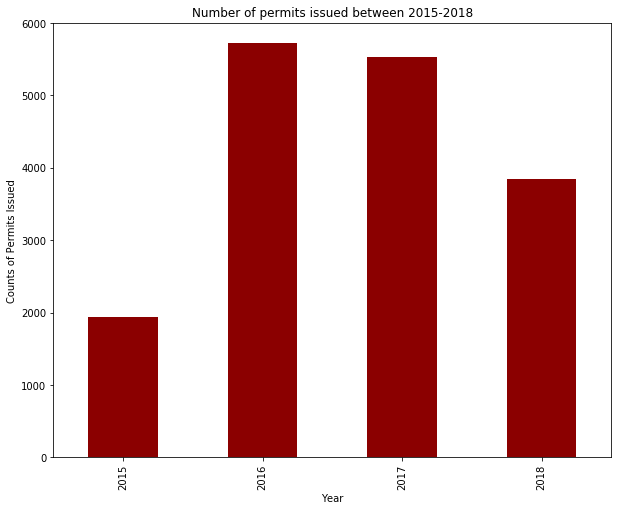

In [55]:
residential_by_year.plot(kind='bar',color='darkred',legend=False)
plt.ylabel('Counts of Permits Issued')
plt.title('Number of permits issued between 2015-2018')

# The average cost for residential permits has been decreasing since 2015.

In [56]:
# construction cost by year residential permits
residential_select1=residential.loc[:,['Year','ConstCost']]
residential_select1=residential_select1.groupby('Year').mean().sort_values('ConstCost',ascending=False)
residential_select1

,ConstCost
Year,
2015,246624.092593
2016,217071.623229
2017,169297.173480
2018,160449.615625


Text(0.5,1,'Average Cost of Construction Overtime')

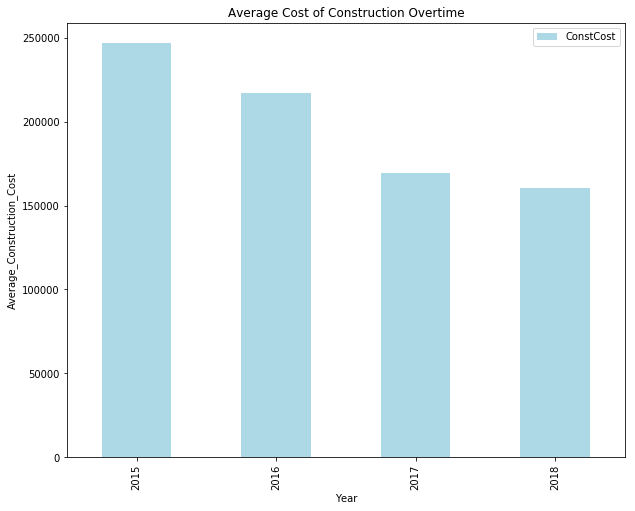

In [57]:
residential_select1.plot(kind='bar',color='lightblue')
plt.ylabel('Average_Construction_Cost')
plt.title('Average Cost of Construction Overtime')

In [58]:
# demo_residential=issued[(residential.Address) ISIN (demolished.Address)]

In [59]:
# find demolished permits
demolished=(issued.loc[issued['PermType']=='CADM'])
demolished.head()

,PermitNo,PermTypeDesc,PermSubtypeDesc,Parcel,Entered,Issued,ConstCost,Address,City,State,...,Contact,PermType,PermSubtype,IVRTrk#,Purpose,CouncilDist,CensusTract,MappedLoc,location,Year
23,201543896,Building Demolition Permit,Demolition Permit - Residential,10509038300,10/08/2015,2015-10-08,4000.0,914 ACKLEN AVE,NASHVILLE,TN,...,Graham Construction Of Tennessee Llc,CADM,CAZ01A001,2075785,Work on this demolition permit must commence w...,17.0,37016200.0,"914 ACKLEN AVE\nNASHVILLE, TN 37203\n(36.13354...","36.133549, -86.783616",2015
30,201620413,Building Demolition Permit,Demolition Permit - Residential,08116022300,05/03/2016,2016-05-03,5000.0,918 SCOVEL ST,NASHVILLE,TN,...,K Jordan Construction Llc,CADM,CAZ01A001,2120019,Work on this demolition permit must commence w...,19.0,37019400.0,"918 SCOVEL ST\nNASHVILLE, TN 37208\n(36.173632...","36.173632, -86.794535",2016
36,201614474,Building Demolition Permit,Demolition Permit - Residential,13102006500,03/31/2016,2016-03-31,7500.0,1923 WARFIELD DR,NASHVILLE,TN,...,Cat3 Restoration Llc,CADM,CAZ01A001,2112314,to demolish exisitng single family residence. ...,25.0,37017901.0,"1923 WARFIELD DR\nNASHVILLE, TN 37215\n(36.102...","36.102592, -86.813442",2016
37,2016039565,Building Demolition Permit,Demolition Permit - Residential,10200007600,08/03/2016,2016-08-03,21000.0,3985 OLD HICKORY BLVD,NASHVILLE,TN,...,SELF CONTRACTOR COMMERCIAL (SEE APPLICANT INFO...,CADM,CAZ01A001,3264459,to demolish existing single family residence. ...,1.0,37013100.0,"3985 OLD HICKORY BLVD\nNASHVILLE, TN 37218\n(3...","36.146926, -86.903582",2016
47,2017033484,Building Demolition Permit,Demolition Permit - Residential,15900008000,05/19/2017,2017-05-19,10000.0,5610 GRANNY WHITE PIKE,BRENTWOOD,TN,...,"URBAN DEVELOPMENT GROUP, LLC",CADM,CAZ01A001,3368029,to demolish existing residence. not to be bur...,34.0,37018700.0,"5610 GRANNY WHITE PIKE\nBRENTWOOD, TN 37027\n(...","36.046438, -86.815953",2017


In [60]:
demolished_select1=demolished.loc[:,['Year','PermitNo','PermType','Address','PermTypeDesc','PermSubtypeDesc','Issued','ConstCost','Zip']]

In [61]:
# see counts of demolishing permits issued by years and zip code
demolished_select2=demolished_select1.loc[:,['Year','Zip','PermitNo']]
demolished_select2=demolished_select2.groupby(['Zip','Year']).count()
demolished_select2.sort_values('PermitNo',ascending=False).head(20)

PermitNo
Zip   Year          
37209 2016       238
      2017       178
37206 2016       132
37209 2018       131
37203 2016       119
37208 2016       111
      2017       101
37215 2016        95
37206 2017        95
37216 2016        87
37203 2017        84
37215 2017        75
37207 2016        70
37208 2018        70
37207 2017        65
37209 2015        61
37206 2015        59
37204 2016        56
37215 2018        54
37204 2017        51

In [62]:
#actual new houses built sub type descritption

#['CAA01R301', 'CAA02R302', 'CAA03R298', 'CAA03R299', 'CAA03R398', 'CAA03R399']

# permits demolished and rebuilt

stypes = ['CAA01R301', 'CAA02R302', 'CAA03R298', 'CAA03R299', 'CAA03R398', 'CAA03R399']

homes = pd.DataFrame(issued.loc[issued.PermSubtype.isin(stypes)])
demos = issued.loc[issued.PermType == 'CADM']
rebuilt=homes.loc[homes.Address.isin(demos.Address)]

https://github.com/nss-data-science-cohort-2/data-question-4-affordable-housing-plaid-platypi-plaidypi.git


# income groups based on Area Median income(AMI) for family of 4

AMI=68000

income_cat_1=0.30* AMI
income_cat_2=60*AMI
income_cat_3=0.80*AMI
income_cat_4=1.20*AMI
income_cat_5>=1.20*AMI

* the families should not spend more than 30 % of their income in all categories
* maximum spending on housing per each category

cat1_spend=68000*0.3*0.3
cat2_spend=68000*0.6*0.3
cat3_spend=68000*0.8*0.3
cat4_spend=68000*1.2*0.3

In [63]:
# calculate categories by income

AMI_2017=68000

AMI_2009=64900
AMI_2013=62300

income_cat_1_2017=0.30* AMI_2017
income_cat_2_2017=0.60*AMI_2017
income_cat_3_2017=0.80*AMI_2017
income_cat_4_2017=1.20*AMI_2017

income_cat_1_2013=0.30* AMI_2013
income_cat_2_2013=0.60*AMI_2013
income_cat_3_2013=0.80*AMI_2013
income_cat_4_2013=1.20*AMI_2013

income_cat_1_2009=0.30* AMI_2009
income_cat_2_2009=0.60*AMI_2009
income_cat_3_2009=0.80*AMI_2009
income_cat_4_2009=1.20*AMI_2009


In [64]:
print(income_cat_1_2017)
print(income_cat_2_2017)
print(income_cat_3_2017)
print(income_cat_4_2017)

20400.0
40800.0
54400.0
81600.0


In [65]:
# calulate housing spending categories

cat1_spend_2017=(income_cat_1_2017*0.3)/12
cat2_spend_2017=(income_cat_2_2017*0.3)/12
cat3_spend_2017=(income_cat_3_2017*0.3)/12
cat4_spend_2017=(income_cat_4_2017*0.3)/12

cat1_spend_2013=(income_cat_1_2013*0.3)/12
cat2_spend_2013=(income_cat_2_2013*0.3)/12
cat3_spend_2013=(income_cat_3_2013*0.3)/12
cat4_spend_2013=(income_cat_4_2013*0.3)/12

cat1_spend_2009=(income_cat_1_2009*0.3)/12
cat2_spend_2009=(income_cat_2_2009*0.3)/12
cat3_spend_2009=(income_cat_3_2009*0.3)/12
cat4_spend_2009=(income_cat_4_2009*0.3)/12


In [66]:
print(cat1_spend_2017)
print(cat2_spend_2017)
print(cat3_spend_2017)
print(cat4_spend_2017)

510.0
1020.0
1360.0
2040.0


In [67]:
sf2013.head()

,Zip,LAT,LNG,APN,DistrictCode,DistrictNo,Address,City,LandValue,ImprovementValue,AppraisedValue,2013 TOTAL ASSD,FinishedArea,Monthly_Housing_Spending,geometry
0,37013,36.052231,-86.632515,135140A00100CO,USD,28,700 PICCADILLY ROW,ANTIOCH,27000.0,80400.0,107400.0,26850.0,1291.0,532.236777,POINT (-86.632515 36.052231)
1,37013,36.052231,-86.632515,135140A00200CO,USD,28,704 PICCADILLY ROW,ANTIOCH,27000.0,92000.0,119000.0,29750.0,1491.0,589.722314,POINT (-86.632515 36.052231)
2,37013,36.052231,-86.632515,135140A00300CO,USD,28,708 PICCADILLY ROW,ANTIOCH,27000.0,109700.0,136700.0,34175.0,1934.0,677.437314,POINT (-86.632515 36.052231)
3,37013,36.052231,-86.632515,135140A00400CO,USD,28,712 PICCADILLY ROW,ANTIOCH,27000.0,93100.0,120100.0,30025.0,1559.0,595.173529,POINT (-86.632515 36.052231)
4,37013,36.052231,-86.632515,135140A00500CO,USD,28,716 PICCADILLY ROW,ANTIOCH,27000.0,91200.0,118200.0,29550.0,1471.0,585.757794,POINT (-86.632515 36.052231)


# create backets 
def backet(x):
    if x<=cat1_spend:
        return 'cat1_spending'
    elif x<=cat2_spend:
         return 'cat2_spending'
    elif x<=cat3_spend:
        return 'cat3_spending'
    elif x<=cat4_spend:
        return 'cat4_spending'
    else:
        return 'Cat5_spending'
     

In [68]:
# create backets for 2009

def backet_2009(x):
    if x<=cat2_spend_2009:
        return 'affordable_housing'
    elif x<=cat4_spend_2009:
         return 'workforce_housing'
    else:
        return 'market_rate'
     

In [69]:
# create backets for 2013

def backet_2013(x):
    if x<=cat2_spend_2013:
        return 'affordable_housing'
    elif x<=cat4_spend_2013:
         return 'workforce_housing'
    else:
        return 'market_rate'

In [70]:
# create backets for 2017

def backet_2017(x):
    if x<=cat2_spend_2017:
        return 'affordable_housing'
    elif x<=cat4_spend_2017:
         return 'workforce_housing'
    else:
        return 'market_rate'

In [71]:
# assing the backets to sf2013,sf2009,sf2017

sf2013['backets']=sf2013.Monthly_Housing_Spending.apply(backet_2013)

sf2009['backets']=sf2009.Monthly_Housing_Spending.apply(backet_2009)

sf2017['backets']=sf2017.Monthly_Housing_Spending.apply(backet_2017)

In [72]:
sf2013.head()

,Zip,LAT,LNG,APN,DistrictCode,DistrictNo,Address,City,LandValue,ImprovementValue,AppraisedValue,2013 TOTAL ASSD,FinishedArea,Monthly_Housing_Spending,geometry,backets
0,37013,36.052231,-86.632515,135140A00100CO,USD,28,700 PICCADILLY ROW,ANTIOCH,27000.0,80400.0,107400.0,26850.0,1291.0,532.236777,POINT (-86.632515 36.052231),affordable_housing
1,37013,36.052231,-86.632515,135140A00200CO,USD,28,704 PICCADILLY ROW,ANTIOCH,27000.0,92000.0,119000.0,29750.0,1491.0,589.722314,POINT (-86.632515 36.052231),affordable_housing
2,37013,36.052231,-86.632515,135140A00300CO,USD,28,708 PICCADILLY ROW,ANTIOCH,27000.0,109700.0,136700.0,34175.0,1934.0,677.437314,POINT (-86.632515 36.052231),affordable_housing
3,37013,36.052231,-86.632515,135140A00400CO,USD,28,712 PICCADILLY ROW,ANTIOCH,27000.0,93100.0,120100.0,30025.0,1559.0,595.173529,POINT (-86.632515 36.052231),affordable_housing
4,37013,36.052231,-86.632515,135140A00500CO,USD,28,716 PICCADILLY ROW,ANTIOCH,27000.0,91200.0,118200.0,29550.0,1471.0,585.757794,POINT (-86.632515 36.052231),affordable_housing


In [73]:
# backets for 2013
# create backet 1
supply2013_backet1=sf2013[sf2013['backets']=='affordable_housing']
# create backet 2
supply2013_backet2=sf2013[sf2013['backets']=='workforce_housing']
# create backet 3
supply2013_backet3=sf2013[sf2013['backets']=='market_rate']


In [74]:
# backets for 2009
# create backet 1
supply2009_backet1=sf2009[sf2009['backets']=='affordable_housing']
# create backet 2
supply2009_backet2=sf2009[sf2009['backets']=='workforce_housing']
# create backet 3
supply2009_backet3=sf2009[sf2009['backets']=='market_rate']


In [75]:
# backets for 2017

# create backet 1
supply2017_backet1=sf2017[sf2017['backets']=='affordable_housing']
# create backet 2
supply2017_backet2=sf2017[sf2017['backets']=='workforce_housing']
# create backet 3
supply2017_backet3=sf2017[sf2017['backets']=='market_rate']



In [76]:
supply2013_backet3.head()

,Zip,LAT,LNG,APN,DistrictCode,DistrictNo,Address,City,LandValue,ImprovementValue,AppraisedValue,2013 TOTAL ASSD,FinishedArea,Monthly_Housing_Spending,geometry,backets
1941,37013,36.052231,-86.632515,14900015602,USD,32,538 BELL RD,ANTIOCH,355400.0,61700.0,417100.0,104275.0,2487.36011,2067.001489,POINT (-86.632515 36.052231),market_rate
1942,37013,36.052231,-86.632515,14900015603,USD,32,544 BELL RD,ANTIOCH,298000.0,112900.0,410900.0,102725.0,1647.00000,2036.276460,POINT (-86.632515 36.052231),market_rate
1944,37013,36.052231,-86.632515,14900015700,USD,32,532 BELL RD,ANTIOCH,954000.0,114300.0,1068300.0,267075.0,3234.44995,5294.120571,POINT (-86.632515 36.052231),market_rate
1966,37013,36.052231,-86.632515,14900035100,USD,28,4226 MOSS RD,ANTIOCH,92400.0,357200.0,449600.0,112400.0,4469.00000,2228.060104,POINT (-86.632515 36.052231),market_rate
2434,37013,36.052231,-86.632515,149020B13700CO,USD,28,2224 COTTAGE HILL DR,ANTIOCH,36000.0,404400.0,440400.0,110100.0,7666.81250,2182.468126,POINT (-86.632515 36.052231),market_rate


In [77]:
# 2009_AMI=64900, 2013_AMI=62300

# Earnings by zip codes  adjusted to homeownership rate used as demand

* number of tax returns with average adjusted gross income(AGI) by zip codes categorized as 
- low income where average AGI <=60% of AMI
- medium income where average AGI is between 60% and 120 % of AMI
- high income where average AGI is above 120% of AMI

# Housing Spending by backets used as supply
* Each group can spends only 30%  of incomes for housing
* Affordable_housing where monthly_housing_spending  <= 30% of 60% of AMI
* Workforce_housing  where monthly_housing_spending is 30% of (60% to 120% of AMI)
* Market_rate where monthly_housing_spending is above 30% of 120 % of AMI


In [78]:
# import income by zip codes data for Tennessee
# NaN for all columns are becuase of blanck rows in the dataset. 
income_by_zip_2009=pd.read_excel('09zp43tn.xls',skiprows=3)
income_by_zip_2009.head()

,ZIP code [1],Size of adjusted gross income,Number of returns,Adjusted gross income (AGI)
0,37010,"$1 under $25,000",660.0,7475.0
1,37010,"$25,000 under $50,000",446.0,16512.0
2,37010,"$50,000 under $75,000",310.0,19266.0
3,37010,"$75,000 under $100,000",241.0,20934.0
4,37010,"$100,000 under $200,000",258.0,32952.0


In [79]:
income_by_zip_2009.columns

Index(['ZIP\ncode [1]', 'Size of adjusted gross income', 'Number of returns',
       'Adjusted gross income (AGI)'],
      dtype='object')

In [80]:
# rename columns
income_by_zip_2009.rename(columns={'ZIP\ncode [1]':'Zip','Size of adjusted gross income':'IncomeBacket','Number of returns':'NumberofPeople','Adjusted gross income (AGI)':'AGI'},inplace=True)
income_by_zip_2009.head()

,Zip,IncomeBacket,NumberofPeople,AGI
0,37010,"$1 under $25,000",660.0,7475.0
1,37010,"$25,000 under $50,000",446.0,16512.0
2,37010,"$50,000 under $75,000",310.0,19266.0
3,37010,"$75,000 under $100,000",241.0,20934.0
4,37010,"$100,000 under $200,000",258.0,32952.0


In [81]:
# remove blank rows and sub total per Zip Code
# AGI is in thousands of dollars
income_by_zip_2009=income_by_zip_2009.dropna()
income_by_zip_2009.tail()

,Zip,IncomeBacket,NumberofPeople,AGI
4673,38588,"$25,000 under $50,000",96.0,3486.0
4674,38588,"$50,000 under $75,000",41.0,2458.0
4675,38588,"$75,000 under $100,000",26.0,2497.0
4676,38588,"$100,000 under $200,000",0.0,0.0
4677,38588,"$200,000 or more",0.0,0.0


In [82]:
income_by_zip_2009=income_by_zip_2009[income_by_zip_2009.Zip!='99999']

In [83]:
# exclude people earning 200,0000 or more
income_by_zip_2009=income_by_zip_2009[income_by_zip_2009['IncomeBacket']!='$200,000 or more']

# AGI is in thousands of dollars
income_by_zip_2009['AGI']=income_by_zip_2009['AGI']*1000

In [84]:
# create monthly average adjusted gross income by zip code
income_by_zip_2009['AGI']=1/12*(income_by_zip_2009['AGI']/income_by_zip_2009['NumberofPeople'])
income_by_zip_2009.head()

,Zip,IncomeBacket,NumberofPeople,AGI
0,37010,"$1 under $25,000",660.0,943.813131
1,37010,"$25,000 under $50,000",446.0,3085.201794
2,37010,"$50,000 under $75,000",310.0,5179.032258
3,37010,"$75,000 under $100,000",241.0,7238.589212
4,37010,"$100,000 under $200,000",258.0,10643.410853


In [85]:
# we used 2016 data for 2017, there is no 2017 data on IRS site

# import income by zip codes data for Tennessee 
# NaN for all columns are becuase of blanck rows in the dataset. 
income_by_zip_2017=pd.read_excel('16zp43tn.xls',skiprows=3)
# print the head
income_by_zip_2017.head()

,ZIP code [1],Size of adjusted gross income,Number of returns,Adjusted gross income (AGI) [4]
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,37010,NaN,2470.0,164793.0
3,37010,"$1 under $25,000",820.0,9304.0
4,37010,"$25,000 under $50,000",470.0,17066.0


In [86]:
# see column names
income_by_zip_2017.columns

Index(['ZIP\ncode [1]', 'Size of adjusted gross income', 'Number of returns',
       'Adjusted gross income (AGI) [4]'],
      dtype='object')

In [87]:
# rename columns
income_by_zip_2017.rename(columns={'ZIP\ncode [1]':'Zip','Number of returns':'NumberofPeople','Size of adjusted gross income':'IncomeBacket','Adjusted gross income (AGI) [4]':'AGI'},inplace=True)
income_by_zip_2017.head()

,Zip,IncomeBacket,NumberofPeople,AGI
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,37010,NaN,2470.0,164793.0
3,37010,"$1 under $25,000",820.0,9304.0
4,37010,"$25,000 under $50,000",470.0,17066.0


In [88]:
income_by_zip_2017.columns

Index(['Zip', 'IncomeBacket', 'NumberofPeople', 'AGI'], dtype='object')

In [89]:
# remove blank rows and sub total per Zip Code
# AGI is in thousands of dollars 
income_by_zip_2017=income_by_zip_2017.dropna()

In [90]:
income_by_zip_2017=income_by_zip_2017[income_by_zip_2017.Zip!='99999']

In [91]:
income_by_zip_2017.head()

,Zip,IncomeBacket,NumberofPeople,AGI
3,37010,"$1 under $25,000",820.0,9304.0
4,37010,"$25,000 under $50,000",470.0,17066.0
5,37010,"$50,000 under $75,000",360.0,22359.0
6,37010,"$75,000 under $100,000",310.0,27061.0
7,37010,"$100,000 under $200,000",420.0,55617.0


In [92]:
# exclude people earning 200,0000 or more
income_by_zip_2017=income_by_zip_2017[income_by_zip_2017['IncomeBacket']!='$200,000 or more']

# AGI is in thousands of dollars
income_by_zip_2017['AGI']=income_by_zip_2017['AGI']*1000
    
# create monthly average adjusted gross income by zip code
income_by_zip_2017['AGI']=1/12*(income_by_zip_2017['AGI']/income_by_zip_2017['NumberofPeople'])
income_by_zip_2017.head()
# we don't have data for 2013, we use the same data we used for 2017
income_by_zip_2013=income_by_zip_2017

In [93]:
# keep only Davidson county data

income_by_zip_2009=income_by_zip_2009[income_by_zip_2009.Zip.isin(sf2009.Zip)]
income_by_zip_2013=income_by_zip_2013[income_by_zip_2013.Zip.isin(sf2013.Zip)]
income_by_zip_2017=income_by_zip_2017[income_by_zip_2017.Zip.isin(sf2017.Zip)]

# home ownership adjusted demand

* assumming people not live in their own houses are the potential buyers

- used home ownership rate data obtained from census burue site for 2017 for all years
- https://www.census.gov/quickfacts/nashvilledavidsonbalancetennessee
- https://fred.stlouisfed.org/series/TNHOWN

In [94]:
# home ownership adjusted demand
# assuming only those not living in owned houses look for houses
# pause this part to run without controlling homeownership rate
income_by_zip_2009['NumberofPeople']=income_by_zip_2009.NumberofPeople*(1-0.54)
income_by_zip_2013['NumberofPeople']=income_by_zip_2013.NumberofPeople*(1-0.54)
income_by_zip_2017['NumberofPeople']=income_by_zip_2017.NumberofPeople*(1-0.54)

* assumming everyone within respective ranges of income could be potential buyer
income_by_zip_2009['NumberofPeople']=income_by_zip_2009.NumberofPeople
income_by_zip_2013['NumberofPeople']=income_by_zip_2013.NumberofPeople
income_by_zip_2017['NumberofPeople']=income_by_zip_2017.NumberofPeople

In [95]:
AMI_17=68000/12

AMI_09=64900/12
AMI_13=62300/12

income_cat_1_17=0.30* AMI_17
income_cat_2_17=0.60*AMI_17
income_cat_3_17=0.80*AMI_17
income_cat_4_17=1.20*AMI_17

income_cat_1_13=0.30* AMI_13
income_cat_2_13=0.60*AMI_13
income_cat_3_13=0.80*AMI_13
income_cat_4_13=1.20*AMI_13

income_cat_1_09=0.30* AMI_09
income_cat_2_09=0.60*AMI_09
income_cat_3_09=0.80*AMI_09
income_cat_4_09=1.20*AMI_09


In [96]:

# create income backets for 2017

def backet_2017_income(x):
    if x<=income_cat_2_17:
        return 'low_income'
    elif x<=income_cat_4_17:
         return 'medium_income'
    else:
        return 'high_income'

In [97]:
# create income backets for 2013

def backet_2013_income(x):
    if x<=income_cat_2_13:
        return 'low_income'
    elif x<=income_cat_4_13:
         return 'medium_income'
    else:
        return 'high_income'

In [98]:
# create income backets for 2009

def backet_2009_income(x):
    if x<=income_cat_2_09:
        return 'low_income'
    elif x<=income_cat_4_09:
         return 'medium_income'
    else:
        return 'high_income'

In [99]:
# sf2013['backets']=sf2013.Monthly_Housing_Spending.apply(backet_2013)

income_by_zip_2009['backets']=income_by_zip_2009.AGI.apply(backet_2009_income)

income_by_zip_2017['backets']=income_by_zip_2017.AGI.apply(backet_2017_income)
# we use the same income we imported for 2017 for 2013 becuase the IRS site is giving error to download 2013 data.
income_by_zip_2013=income_by_zip_2017
income_by_zip_2013['backets']=income_by_zip_2013.AGI.apply(backet_2013_income)

In [100]:
income_by_zip_2017.head()

,Zip,IncomeBacket,NumberofPeople,AGI,backets
19,37013,"$1 under $25,000",7479.6,1115.108651,low_income
20,37013,"$25,000 under $50,000",6854.0,3008.053691,low_income
21,37013,"$50,000 under $75,000",2778.4,5045.102097,medium_income
22,37013,"$75,000 under $100,000",1228.2,7170.474407,high_income
23,37013,"$100,000 under $200,000",1044.2,10592.584435,high_income


In [101]:
# create backet 1 for demand
demand2017_backet1=income_by_zip_2017[income_by_zip_2017['backets']=='low_income']
# create backet 2 for demand
demand2017_backet2=income_by_zip_2017[income_by_zip_2017['backets']=='medium_income']
# create backet 3 for demand
demand2017_backet3=income_by_zip_2017[income_by_zip_2017['backets']=='high_income']

In [102]:
# create backet 1 for demand
demand2013_backet1=income_by_zip_2017[income_by_zip_2017['backets']=='low_income']
# create backet 2 for demand
demand2013_backet2=income_by_zip_2017[income_by_zip_2017['backets']=='medium_income']
# create backet 3 for demand
demand2013_backet3=income_by_zip_2013[income_by_zip_2013['backets']=='high_income']

In [103]:
demand2017_backet2.head()

,Zip,IncomeBacket,NumberofPeople,AGI,backets
21,37013,"$50,000 under $75,000",2778.4,5045.102097,medium_income
37,37015,"$50,000 under $75,000",621.0,5137.345679,medium_income
109,37027,"$50,000 under $75,000",1191.4,5174.678250,medium_income
333,37064,"$50,000 under $75,000",1361.6,5167.314189,medium_income
365,37072,"$50,000 under $75,000",1044.2,5106.644640,medium_income


In [104]:
# create backet 1 for demand
demand2009_backet1=income_by_zip_2009[income_by_zip_2009['backets']=='low_income']
# create backet 2 for demand
demand2009_backet2=income_by_zip_2009[income_by_zip_2009['backets']=='medium_income']
# create backet 3 for demand
demand2009_backet3=income_by_zip_2009[income_by_zip_2009['backets']=='high_income']

In [105]:
demand2017_backet1.head()

,Zip,IncomeBacket,NumberofPeople,AGI,backets
19,37013,"$1 under $25,000",7479.6,1115.108651,low_income
20,37013,"$25,000 under $50,000",6854.0,3008.053691,low_income
35,37015,"$1 under $25,000",1361.6,1062.865991,low_income
36,37015,"$25,000 under $50,000",1131.6,3029.098916,low_income
107,37027,"$1 under $25,000",2953.2,773.533229,low_income



### There were huge shortages of affordable housing in 2017 about 19500 units.
* literatures indicates that lower valued houses were sold out , supply was not growing fast enough.

### In 2013 just only 227 affordable houses were surplus

### In 2009 there were 4720 surplus affordable houses


In [106]:
# print demand and supply for affordable_housing in 2009,2013 and 2017
print('demand_b1_09');print(round(demand2009_backet1.NumberofPeople.sum(),0));print('supply_b1_09');print(round(supply2009_backet1.backets.count(),0))
print('demand_b1_13');print(round(demand2013_backet1.NumberofPeople.sum(),0));print('supply_b1_13');print(round(supply2013_backet1.backets.count(),0))
print('demand_b1_17');print(round(demand2017_backet1.NumberofPeople.sum(),0));print('supply_b1_17');print(round(supply2017_backet1.backets.count(),0))

demand_b1_09
123000.0
supply_b1_09
127720
demand_b1_13
126160.0
supply_b1_13
126387
demand_b1_17
126160.0
supply_b1_17
97171


### In 2009 there were about 9000 surplus units of houses
### In contrary , in 2013 there was over 9500 shortages
### But in 2017 it looks there were about 1500 surplus units of houses.

In [107]:
# print total demand and supply in 2009,2013 and 2017
print('tot_demand_2009');print(round(income_by_zip_2009.NumberofPeople.sum(),0));print('tot_supply_2009');print(round(sf2009.backets.count(),0))
print('tot_demand_2013');print(round(income_by_zip_2013.NumberofPeople.sum(),0));print('tot_supply_2013'),print(round(sf2013.backets.count(),0))
print('tot_demand_2017');print(round(income_by_zip_2017.NumberofPeople.sum(),0));print('tot_supply_2017'),print(round(sf2017.backets.count(),0))

tot_demand_2009
175694.0
tot_supply_2009
183406
tot_demand_2013
195523.0
tot_supply_2013
186269
tot_demand_2017
195523.0
tot_supply_2017
197113


(None, None)

* there was excess supply for affordable as well work_force houses in 2009
* However, there was shortage for market rate houses , 
* but in 2009 it could be there were less houses valued that high becuase of the financial crissis 
* There were surplus for working_force group in all 3 years

In [108]:
# shortage for affordable_housing in 2009
print('demand_b1');print(round(demand2009_backet1.NumberofPeople.sum(),0));print('supply_b1');print(round(supply2009_backet1.backets.count(),0))
# shortage in work force group is lowest in 2009
print('demand_b2');print(round(demand2009_backet2.NumberofPeople.sum(),0));print('supply_b2');print(round(supply2009_backet2.backets.count(),0))
# demand and supply for market group in 2009
print('demand_b3');print(round(demand2009_backet3.NumberofPeople.sum(),0));print('supply_b3');print(round(supply2009_backet3.backets.count(),0))

demand_b1
123000.0
supply_b1
127720
demand_b2
23352.0
supply_b2
41204
demand_b3
29342.0
supply_b3
14482


In [109]:
# demand and supply by backets in 2017
print('demand_b1');print(round(demand2017_backet1.NumberofPeople.sum(),0));print('supply_b1');print(round(supply2017_backet1.backets.count(),0))
print('demand_b2');print(round(demand2017_backet2.NumberofPeople.sum(),0));print('supply_b2');print(round(supply2017_backet2.backets.count(),0))
print('demand_b3');print(round(demand2017_backet3.NumberofPeople.sum(),0));print('supply_b3');print(round(supply2017_backet3.backets.count(),0))

demand_b1
126160.0
supply_b1
97171
demand_b2
28193.0
supply_b2
71019
demand_b3
41170.0
supply_b3
28923


In [110]:
# demand and supply by backets in 2013
print('demand_b1');print(round(demand2013_backet1.NumberofPeople.sum(),0));print('supply_b1');print(round(supply2013_backet1.backets.count(),))
print('demand_b2');print(round(demand2013_backet2.NumberofPeople.sum(),0));print('supply_b2');print(round(supply2013_backet2.backets.count(),))
print('demand_b3');print(round(demand2013_backet3.NumberofPeople.sum(),0));print('supply_b3');print(round(supply2013_backet3.backets.count(),))

demand_b1
126160.0
supply_b1
126387
demand_b2
28193.0
supply_b2
42974
demand_b3
41170.0
supply_b3
16908


# prediction model
demand=a+b*population-c*rate_house_own+d*growth_rate-d*unemploy_rate + ei

In [111]:
#demand and suppy by zip code in 2009 for backet 1

demand_2009_b1=demand2009_backet1.loc[:,['Zip','NumberofPeople']].groupby('Zip').sum().sort_values('NumberofPeople',ascending=False)
supply_2009_b1= supply2009_backet1.loc[:,['Zip','backets']].groupby('Zip').count().sort_values('backets',ascending=False)

In [112]:
# join dd and ss data for 2009 backet1
DD_SS_2009_Backet1=demand_2009_b1.join(supply_2009_b1)
DD_SS_2009_Backet1.rename(columns={'NumberofPeople':'demand_b1_09','backets':'supply_b1_09'},inplace=True)
DD_SS_2009_Backet1.supply_b1_09.fillna(0,inplace=True)
DD_SS_2009_Backet1['surplus']=DD_SS_2009_Backet1.supply_b1_09-DD_SS_2009_Backet1.demand_b1_09
print(DD_SS_2009_Backet1.supply_b1_09.min())
DD_SS_2009_Backet1.head()

1


,demand_b1_09,supply_b1_09,surplus
Zip,,,
37013,12713.02,18034,5320.98
37211,12160.56,14412,2251.44
37207,6433.56,9397,2963.44
37115,6413.78,8869,2455.22
37209,5784.50,6456,671.50


* 19 zip codes in Davidson County had surplus in 2009

In [113]:
# find the surplus and shortage zip codes for affordable housing

surplus_2009_Backet1=DD_SS_2009_Backet1[DD_SS_2009_Backet1.surplus>0]
shortage_2009_Backet1=DD_SS_2009_Backet1[DD_SS_2009_Backet1.surplus<0]
print(surplus_2009_Backet1.shape)
print(shortage_2009_Backet1.shape)

(19, 3)
(15, 3)


- only Zip codes where affordable houses were reported included in this plot
- zip codes around the downtown have shortage 
- however, this could be buecuase number of residents around there are less in number as it is commericial area

Text(0,0.5,'total_house_units')

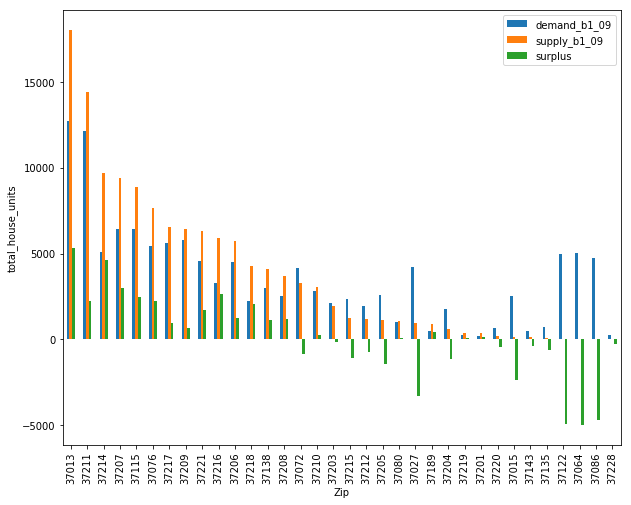

In [114]:
# top 20 zips with non zero supplies
top_20_suppy_b1_09=DD_SS_2009_Backet1.sort_values('supply_b1_09',ascending=False)
top_20_suppy_b1_09.head(20)
top_20_suppy_b1_09.plot(kind='bar')
plt.ylabel('total_house_units')

In [115]:
#demand and suppy by zip code in 2013 for backet 1

demand_2013_b1=demand2013_backet1.loc[:,['Zip','NumberofPeople']].groupby('Zip').sum().sort_values('NumberofPeople',ascending=False)
supply_2013_b1= supply2013_backet1.loc[:,['Zip','backets']].groupby('Zip').count().sort_values('backets',ascending=False)

In [116]:
# join dd and ss data for 2013 backet1
DD_SS_2013_Backet1=demand_2013_b1.join(supply_2013_b1)
DD_SS_2013_Backet1.rename(columns={'NumberofPeople':'demand_b1_13','backets':'supply_b1_13'},inplace=True)
DD_SS_2013_Backet1.supply_b1_13.min()

1

In [117]:
# calculate surplus
DD_SS_2013_Backet1['surplus']=DD_SS_2013_Backet1.supply_b1_13-DD_SS_2013_Backet1.demand_b1_13
DD_SS_2013_Backet1.head()

,demand_b1_13,supply_b1_13,surplus
Zip,,,
37013,14333.6,18913,4579.4
37211,11748.4,14000,2251.6
37207,6858.6,9479,2620.4
37115,6559.6,8955,2395.4
37122,5828.2,40,-5788.2


In [118]:
# find the surplus and shortage zip codes
surplus_2013_Backet1=DD_SS_2013_Backet1[DD_SS_2013_Backet1.surplus>0]
shortage_2013_Backet1=DD_SS_2013_Backet1[DD_SS_2013_Backet1.surplus<0]
print(surplus_2013_Backet1.shape)
print(shortage_2013_Backet1.shape)

(19, 3)
(14, 3)


Text(0,0.5,'total_house_units')

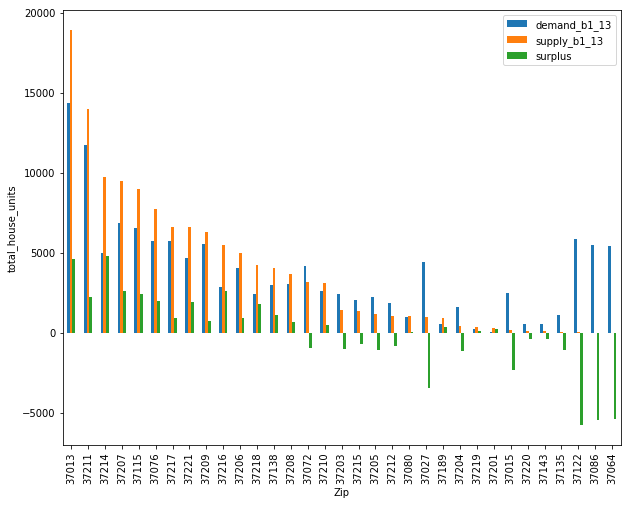

In [119]:
# top 20 zips with non zero supplies
top_20_suppy_b1_13=DD_SS_2013_Backet1.sort_values('supply_b1_13',ascending=False)
top_20_suppy_b1_13.head(20)
top_20_suppy_b1_13.plot(kind='bar')
plt.ylabel('total_house_units')

In [120]:
#demand and suppy by zip code in 2017 for backet 1

demand_2017_b1=demand2017_backet1.loc[:,['Zip','NumberofPeople']].groupby('Zip').sum().sort_values('NumberofPeople',ascending=False)
supply_2017_b1= supply2017_backet1.loc[:,['Zip','backets']].groupby('Zip').count().sort_values('backets',ascending=False)

In [121]:
# join dd and ss data for 2017 backet1
DD_SS_2017_Backet1=demand_2017_b1.join(supply_2017_b1)
DD_SS_2017_Backet1.rename(columns={'NumberofPeople':'demand_b1_17','backets':'supply_b1_17'},inplace=True)

DD_SS_2017_Backet1['surplus']=DD_SS_2017_Backet1.supply_b1_17-DD_SS_2017_Backet1.demand_b1_17

* only 10 zip codes had surplus in 2017

In [122]:
# find the surplus and shortage zip codes
surplus_2017_Backet1=DD_SS_2017_Backet1[DD_SS_2017_Backet1.surplus>0]
shortage_2017_Backet1=DD_SS_2017_Backet1[DD_SS_2017_Backet1.surplus<0]
surplus_2017_Backet1
print(surplus_2017_Backet1.shape)
print(shortage_2017_Backet1.shape)

(10, 3)
(23, 3)


In [123]:
surplus_2017_Backet1

,demand_b1_17,supply_b1_17,surplus
Zip,,,
37013,14333.6,17498,3164.4
37207,6858.6,8227,1368.4
37115,6559.6,8169,1609.4
37076,5750.0,6901,1151.0
37217,5740.8,6011,270.2
37214,4977.2,7548,2570.8
37138,2990.0,3515,525.0
37210,2612.8,2709,96.2
37218,2442.6,3743,1300.4


In [124]:
shortage_2017_Backet1.head()

,demand_b1_17,supply_b1_17,surplus
Zip,,,
37211,11748.4,10182,-1566.4
37122,5828.2,20,-5808.2
37209,5552.2,3703,-1849.2
37086,5446.4,1,-5445.4
37064,5423.4,2,-5421.4


### Majority of  Zip Codes had shortage in 2017

Text(0,0.5,'total_house_units')

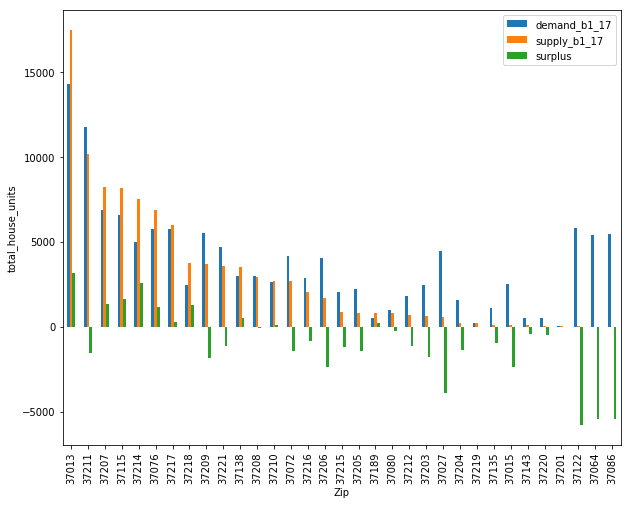

In [125]:
# top 20 zips with non zero supplies
top_20_suppy_b1_17=DD_SS_2017_Backet1.sort_values('supply_b1_17',ascending=False)
top_20_suppy_b1_17.head(20)
top_20_suppy_b1_17.plot(kind='bar')
plt.ylabel('total_house_units')

In [126]:
# reset index for surplus_2009_Backet1 data

surplus_2009_B1=surplus_2009_Backet1.reset_index()
# supply by zipcodes with surplus in 2009 for affordable housing
surplus_2009=supply2009_backet1[supply2009_backet1.Zip.isin (surplus_2009_B1.Zip)]

# reset index for surplus_2013_Backet1 data

surplus_2013_B1=surplus_2013_Backet1.reset_index()
# supply by zipcodes with surplus in 2013 for affordable housing
surplus_2013=supply2013_backet1[supply2013_backet1.Zip.isin (surplus_2013_B1.Zip)]

# reset index for surplus_2017_Backet1 data
surplus_2017_B1=surplus_2017_Backet1.reset_index()
# supply by zipcodes with surplus in 2017 for affordable housing
surplus_2017=supply2017_backet1[supply2017_backet1.Zip.isin (surplus_2017_B1.Zip)]

In [127]:
# keep only columns to be used for mapping

# 2009 data
surplus_2009_b1=surplus_2009.loc[:,['Zip','LAT','LNG','Monthly_Housing_Spending']]
surplus_2009_b1=surplus_2009_b1.groupby(['Zip','LAT','LNG']).mean().reset_index()

# 2013 data

surplus_2013_backet1=surplus_2013.loc[:,['Zip','LAT','LNG','Monthly_Housing_Spending']]

surplus_2013_b1=surplus_2013_backet1.groupby(['Zip','LAT','LNG']).mean().reset_index()


# 2017 data
surplus_2017_backet1=surplus_2017.loc[:,['Zip','LAT','LNG','Monthly_Housing_Spending']]
surplus_2017_b1=surplus_2017_backet1.groupby(['Zip','LAT','LNG']).mean().reset_index()



###  In 2009 zip codes 37208,37210 and 37207 were most affordable among with surplus zip codes
###  In 2013 zip codes 37207,37218 and 37210 were most affordable among with surplus zip codes 
### In contrast, in 2017 zip code 37013,Antioch  Which is generally percieved as more affordable area was the least affordable among with surplus zip codes. In average housing_spending increased by 25% between 2013 and 2017 in Antioch.

In [128]:
surplus_2017_b1.sort_values('Monthly_Housing_Spending')

,Zip,LAT,LNG,Monthly_Housing_Spending
9,37218,36.164095,-86.889416,617.012811
5,37207,36.233774,-86.775969,657.472858
2,37115,36.253847,-86.695530,662.992708
8,37217,36.108666,-86.656722,687.033268
4,37189,36.298880,-86.834803,694.812864
6,37210,36.149263,-86.732969,696.819776
3,37138,36.244014,-86.609391,712.695457
1,37076,36.145195,-86.576632,742.606432
0,37013,36.052231,-86.632515,747.180734
7,37214,36.162189,-86.670867,757.382395


In [129]:
surplus_2013_b1.sort_values('Monthly_Housing_Spending').head(10)

,Zip,LAT,LNG,Monthly_Housing_Spending
9,37208,36.177714,-86.808023,385.632701
8,37207,36.233774,-86.775969,464.080936
16,37218,36.164095,-86.889416,495.858276
11,37210,36.149263,-86.732969,502.116438
17,37219,36.166811,-86.783177,517.119061
3,37115,36.253847,-86.695530,525.944679
15,37217,36.108666,-86.656722,539.984110
10,37209,36.185400,-86.948570,556.954495
12,37211,36.067234,-86.723711,575.403778
4,37138,36.244014,-86.609391,578.893293


In [130]:
surplus_2009_b1.sort_values('Monthly_Housing_Spending').head(10)

,Zip,LAT,LNG,Monthly_Housing_Spending
9,37208,36.177714,-86.808023,407.166363
11,37210,36.149263,-86.732969,493.979553
8,37207,36.233774,-86.775969,504.139135
17,37219,36.166811,-86.783177,535.005153
16,37218,36.164095,-86.889416,537.020890
3,37115,36.253847,-86.695530,558.100195
10,37209,36.185400,-86.948570,563.047470
15,37217,36.108666,-86.656722,583.089011
4,37138,36.244014,-86.609391,597.730129
14,37216,36.216580,-86.726854,599.050891


In [131]:
# create data for map
surplus_2009_map=surplus_2009_b1

surplus_2013_map=surplus_2013_b1

surplus_2017_map=surplus_2017_b1



In [132]:
nashville_map_09 = folium.Map(location = [36.1627, -86.7816], zoom_start = 10)
nashville_map_13 = folium.Map(location = [36.1627, -86.7816], zoom_start = 10)
nashville_map_17 = folium.Map(location = [36.1627, -86.7816], zoom_start = 10)

### Zip Codes With Surplus in 2009

In [133]:
for row in surplus_2009_map.iterrows():
    row_values = row[1] 
    location = [row_values['LAT'], row_values['LNG']]
    popup = 'Year:'+'2009'+'<br/>'+'Zip Code: ' + str(row_values['Zip']) + '<br/>' + 'Housing_Spending: ' + str(round(row_values['Monthly_Housing_Spending'],0))
    
    marker = folium.Marker(location=location, popup=popup).add_to(nashville_map_09)
    marker.add_to(nashville_map_09)
              
        
# Show map

nashville_map_09


### Zip codes with surplus in 2013

In [134]:
for row in surplus_2013_map.iterrows():
    row_values = row[1] 
    location = [row_values['LAT'], row_values['LNG']]
    popup = 'Year:'+'2013'+'<br/>'+'Zip Code: ' + str(row_values['Zip']) + '<br/>' + 'Housing_Spending: ' + str(round(row_values['Monthly_Housing_Spending'],0))
    
    
 
    marker = folium.Marker(location=location, popup=popup).add_to(nashville_map_13)
    marker.add_to(nashville_map_13)
              
        
# Show map

nashville_map_13


### Zip codes with surplus in 2017

In [135]:
for row in surplus_2017_map.iterrows():
    row_values = row[1] 
    location = [row_values['LAT'], row_values['LNG']]
    popup = 'Year:'+'2017'+'<br/>'+'Zip Code: ' + str(row_values['Zip']) + '<br/>' + 'Housing_Spending: ' + str(round(row_values['Monthly_Housing_Spending'],0))
    
    
    marker = folium.Marker(location=location, popup=popup).add_to(nashville_map_17)
    marker.add_to(nashville_map_17)
              
        
# Show map

nashville_map_17
